In [3]:
# pip install fredapi pandas numpy statsmodels
import os
import numpy as np
import pandas as pd
from fredapi import Fred
from statsmodels.tsa.vector_ar.vecm import coint_johansen, VECM
from statsmodels.tsa.api import VAR
from statsmodels.stats.stattools import durbin_watson
from statsmodels.stats.diagnostic import acorr_ljungbox

## Pipeline to prepare data, check cointegration, fit VECM and fit VAR in levels to derive IRFs

In [4]:

# ── 0) FRED API key ─────────────────────────────────────────────────────────────

fred = Fred(api_key="6778de290574049191b08f6b46e3943e")


In [5]:

# ── 1) Pull series ─────────────────────────────────────────────────────────────
# Real GDP, quarterly; CPI, monthly
gdp = fred.get_series("GDPC1")      # Real GDP, quarterly
cpi = fred.get_series("CPIAUCSL")   # CPI, monthly

# Convert to DataFrames with nice column names
gdp = gdp.to_frame(name="gdp")      # index: DatetimeIndex (quarter end)
cpi = cpi.to_frame(name="cpi")      # index: DatetimeIndex (month end)



In [6]:
# ── 2) Make CPI quarterly ──────────────────────────────────────────────────────

cpi_q = cpi.resample("Q-DEC").last()
cpi_q.index = cpi_q.index.to_period("Q-DEC")

# GDP is already quarterly, so force same frequency
gdp_q = gdp.copy()
gdp_q.index = gdp_q.index.to_period("Q-DEC")

# ── 3) Merge to one quarterly DataFrame & take logs ────────────────────────────
df_q = pd.concat([gdp_q, cpi_q], axis=1).dropna()    # inner join on common quarters
macro_levels = np.log(df_q).rename(columns={"gdp": "log_gdp", "cpi": "log_cpi"})


/tmp/ipykernel_14103/2654948868.py:3: FutureWarning: 'Q-DEC' is deprecated and will be removed in a future version, please use 'QE-DEC' instead.
  cpi_q = cpi.resample("Q-DEC").last()


In [7]:
print(df_q.head())
print(df_q.columns)        
print(macro_levels.head())
macro_levels.info()

             gdp    cpi
1947Q1  2182.681  22.00
1947Q2  2176.892  22.08
1947Q3  2172.432  22.84
1947Q4  2206.452  23.41
1948Q1  2239.682  23.50
Index(['gdp', 'cpi'], dtype='object')
         log_gdp   log_cpi
1947Q1  7.688309  3.091042
1947Q2  7.685653  3.094672
1947Q3  7.683603  3.128513
1947Q4  7.699141  3.153163
1948Q1  7.714089  3.157000
<class 'pandas.core.frame.DataFrame'>
PeriodIndex: 314 entries, 1947Q1 to 2025Q2
Freq: Q-DEC
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   log_gdp  314 non-null    float64
 1   log_cpi  314 non-null    float64
dtypes: float64(2)
memory usage: 7.4 KB


In [8]:
from statsmodels.tsa.api import VAR
import matplotlib.pyplot as plt

In [9]:

# ── 4) Johansen cointegration test (ecdet='const', K=2) ─
# det_order=0  => constant restricted to the cointegration relation ("const")
# k_ar_diff = K-1 (R's K=2 => 1)
jres = coint_johansen(macro_levels, det_order=0, k_ar_diff=1)

# Trace statistics (like R 'trace' test) and critical values
print("Trace statistics:", jres.lr1)      # array of trace stats
print("Critical values (90/95/99%):\n", jres.cvt)  # rows per rank, cols per quantile



# ── 5) Fit VECM (rank=1,  k_ar_diff=1, constant in coint space) ──────────
vecm = VECM(macro_levels, k_ar_diff=1, coint_rank=1, deterministic="co")
vres = vecm.fit()

print(vres.summary())



Trace statistics: [9.95849448 4.35728227]
Critical values (90/95/99%):
 [[13.4294 15.4943 19.9349]
 [ 2.7055  3.8415  6.6349]]
Det. terms outside the coint. relation & lagged endog. parameters for equation log_gdp
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0368      0.012      2.966      0.003       0.012       0.061
L1.log_gdp     0.1223      0.056      2.194      0.028       0.013       0.232
L1.log_cpi    -0.0992      0.073     -1.359      0.174      -0.242       0.044
Det. terms outside the coint. relation & lagged endog. parameters for equation log_cpi
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0043      0.008      0.543      0.587      -0.011       0.020
L1.log_gdp     0.0015      0.036      0.042      0.966      -0.069 

In [10]:
# 3) VAR in levels for IRF/FEVD (R: vec2var). Use p=K=2 lags 
var = VAR(macro_levels).fit(maxlags=4, ic=None, trend='c')  
print(var.summary())

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Wed, 08, Oct, 2025
Time:                     16:54:31
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                   -18.9489
Nobs:                     310.000    HQIC:                  -19.0792
Log likelihood:           2108.97    FPE:                4.74653e-09
AIC:                     -19.1659    Det(Omega_mle):     4.48248e-09
--------------------------------------------------------------------
Results for equation log_gdp
                coefficient       std. error           t-stat            prob
-----------------------------------------------------------------------------
const              0.036640         0.028300            1.295           0.195
L1.log_gdp         1.086706         0.058272           18.649           0.000
L1.log_cpi         0.026227         0.095615            0.274         

## Interpretations: VAR(4) Diagnostic Interpretation

# GDP Equation
+ GDP depends strongly on its own recent past.
+ Higher-order GDP lags (L2–L4) are small/insignificant → diminishing influence beyond one quarter.
+ CPI lags mostly insignificant → inflation shocks don’t meaningfully drive GDP in short run.
✅ GDP behaves like a near-AR(1) process: stable but persistent.

# CPI Equation
+ CPI shocks fade slowly, matching economic intuition (inflation inertia).
✅ Inflation properly modeled as a multi-lag(AR(4)) process with gradual mean reversion

ρ(log_gdp, log_cpi) = 0.176 → modest positive correlation; expected since inflation and GDP co-move slightly.



In [11]:

# --- Durbin-Watson test for each residual series ---
dw_stats = durbin_watson(var.resid)
for col, val in zip(macro_levels.columns, dw_stats):
    print(f"Durbin-Watson for {col}: {val:.2f}")

# --- Ljung-Box (Portmanteau) test for overall autocorrelation ---
resid_arr = getattr(var.resid, "values", np.asarray(var.resid))
for i, col in enumerate(macro_levels.columns):
    lb = acorr_ljungbox(resid_arr[:, i], lags=[12], return_df=True)
    print(f"\nLjung-Box Portmanteau test (lag 12) for {col}:")
    print(lb)



Durbin-Watson for log_gdp: 2.01
Durbin-Watson for log_cpi: 1.95

Ljung-Box Portmanteau test (lag 12) for log_gdp:
     lb_stat  lb_pvalue
12  4.505632   0.972492

Ljung-Box Portmanteau test (lag 12) for log_cpi:
      lb_stat  lb_pvalue
12  13.600073   0.326972


In [12]:
# IRFs (12Q), orthogonalized 
irf_cpi = var.irf(12)   



# Helper: pull CPI shock → GDP response (and GDP shock → CPI) as 1D arrays (Q1..Q12)
resp_gdp_from_cpi = irf_cpi.irfs[1:, macro_levels.columns.get_loc("log_gdp"),
                                     macro_levels.columns.get_loc("log_cpi")]
resp_cpi_from_gdp = irf_cpi.irfs[1:, macro_levels.columns.get_loc("log_cpi"),
                                     macro_levels.columns.get_loc("log_gdp")]

In [13]:
# FEVD (12Q)
fevd = var.fevd(12)
print(fevd.summary())  # prints variance shares by shock for each variable

# Forecast (optional)
fc = var.forecast_interval(macro_levels.values[-var.k_ar:], steps=12, alpha=0.05)
# fc is (mean, lower, upper)

FEVD for log_gdp
       log_gdp   log_cpi
0     1.000000  0.000000
1     0.999899  0.000101
2     0.997877  0.002123
3     0.993617  0.006383
4     0.988742  0.011258
5     0.982403  0.017597
6     0.975410  0.024590
7     0.968436  0.031564
8     0.961476  0.038524
9     0.954759  0.045241
10    0.948483  0.051517
11    0.942682  0.057318

FEVD for log_cpi
       log_gdp   log_cpi
0     0.031107  0.968893
1     0.051548  0.948452
2     0.070697  0.929303
3     0.091965  0.908035
4     0.109038  0.890962
5     0.123742  0.876258
6     0.136531  0.863469
7     0.147820  0.852180
8     0.158034  0.841966
9     0.167409  0.832591
10    0.176135  0.823865
11    0.184367  0.815633


None


## Scenario Overlays and ECL Mapping

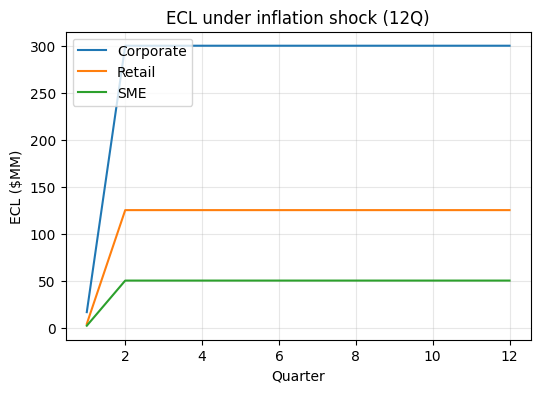

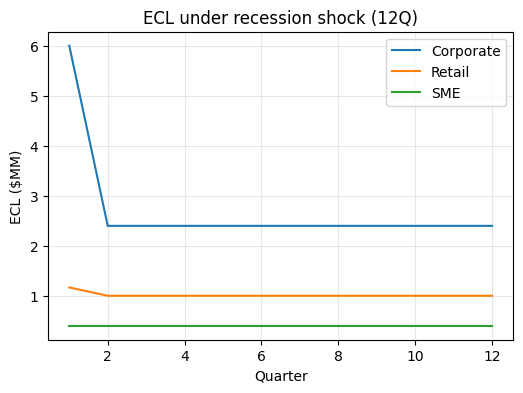

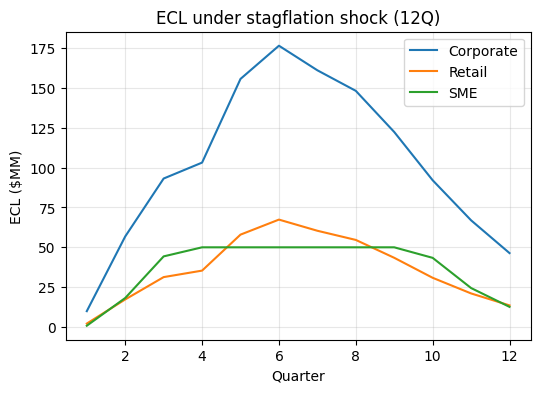

In [14]:
# ---- Build scenario vectors from IRFs (length = 12 quarters) ----
k = 3.0  # stress scaler (same as your R `* 3`)
inflation_path  = resp_gdp_from_cpi * k     # GDP response to a CPI shock
recession_path  = resp_cpi_from_gdp * k     # CPI response to a GDP shock
stagflation_path = 0.5*(inflation_path + recession_path)

scenarios = {
    "inflation":   inflation_path,
    "recession":   recession_path,
    "stagflation": stagflation_path
}

# ---- Stylized portfolio ----
portfolio = pd.DataFrame({
    "Segment":  ["Retail", "SME", "Corporate"],
    "Exposure": [1e9, 5e8, 2e9],
    "PD_Base":  [0.02, 0.04, 0.03],
    "LGD":      [0.50, 0.40, 0.60]
})

# Elasticities: %ΔPD per 1pp Δmacro (your calibration knobs)
elasticity = {"Retail": -0.12, "SME": -0.18, "Corporate": -0.10}

def pd_multiplier(irf_val, seg):
    # IRF is in log units; multiplied by 100 to treat it like "pp".
    # Keep the same mapping for parity:
    return np.exp(elasticity[seg] * irf_val * 100)

pd_floor, pd_cap = 0.002, 0.25

# ---- Expand to quarter-by-quarter ECLs ----
rows = []
for scn, path in scenarios.items():
    for q, macro_impulse in enumerate(path, start=1):
        for _, r in portfolio.iterrows():
            mult = pd_multiplier(macro_impulse, r.Segment)
            pd_stress = np.clip(r.PD_Base * mult, pd_floor, pd_cap)
            ecl = r.Exposure * pd_stress * r.LGD / 1e6  # $MM
            rows.append((scn, q, r.Segment, pd_stress, ecl))

ecl_df = pd.DataFrame(rows, columns=["Scenario","Quarter","Segment","PD_Stress","ECL_MM"])

# ---- Visuals ----
for scn, sub in ecl_df.groupby("Scenario"):
    fig, ax = plt.subplots(figsize=(6,4))
    for seg, segdf in sub.groupby("Segment"):
        ax.plot(segdf["Quarter"], segdf["ECL_MM"], label=seg)
    ax.set_title(f"ECL under {scn} shock (12Q)")
    ax.set_xlabel("Quarter"); ax.set_ylabel("ECL ($MM)")
    ax.legend(); ax.grid(True, alpha=0.3)
    plt.show()


## Interpretations: ECL Paths

Prolonged inflation risk and transient growth shocks

Inflation scenario: 
+ Inflation shocks propagate more gradually across quarters (VAR(4) captures this inertia).
+ ECL now rises more steadily rather than jumping immediately — slow-burn inflation stress.
+ Corporate losses dominate in dollar terms (largest exposure), but SMEs show higher proportional sensitivity (higher elasticity).

Recession scenario:
+ GDP shocks mean-revert faster, reflected in ECL peaking early (by ~Q2–Q3) then fading.

Stagflation: 
+ Since CPI is persistent and GDP reverts quickly, the combination yields a bell-shaped ECL profile:
    + Initial inflation pressure + GDP contraction = spike.
    + Recovery phase = gradual ECL normalization.


## Forecasting

In [15]:


# Forecast horizon
n_ahead = 12
lag_order = var.k_ar
forecast_input = macro_levels.values[-lag_order:]

# Forecast log-levels
fc = var.forecast(y=forecast_input, steps=n_ahead)
forecast_index = pd.period_range(macro_levels.index[-1] + 1, periods=n_ahead, freq='Q')
df_forecast = pd.DataFrame(fc, index=forecast_index, columns=[f"{c}_log_fc" for c in macro_levels.columns])

# Combine actual + forecast
df_combined = pd.concat([
    macro_levels.rename(columns=lambda c: f"{c}_log_actual"),
    df_forecast
])

# Back-transform to actual scale
df_combined["GDP_forecast"] = np.exp(df_combined["log_gdp_log_fc"])
df_combined["CPI_forecast"] = np.exp(df_combined["log_cpi_log_fc"])


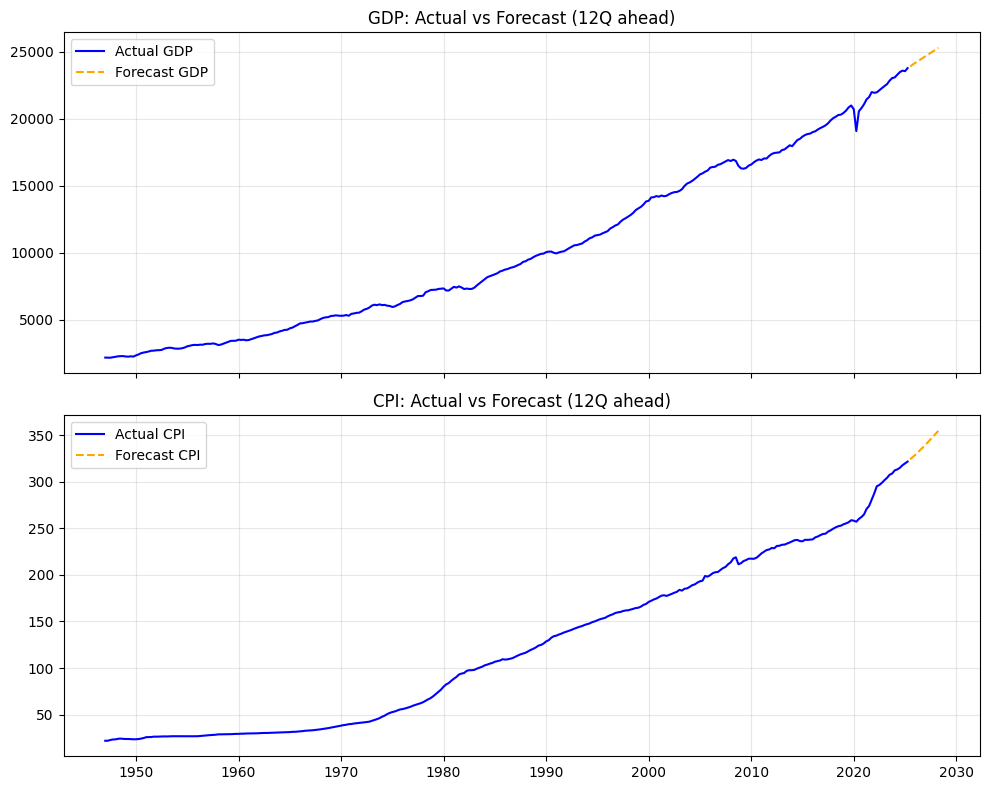

In [20]:
# Convert index to datetime for plotting

macro_levels.index = macro_levels.index.to_timestamp()
df_combined.index = df_combined.index.to_timestamp()

fig, axes = plt.subplots(2, 1, figsize=(10, 8), sharex=True)

# GDP actual vs forecast
axes[0].plot(np.exp(macro_levels["log_gdp"]), label="Actual GDP", color="blue")
axes[0].plot(df_combined["GDP_forecast"], label="Forecast GDP", color="orange", linestyle="--")
axes[0].set_title("GDP: Actual vs Forecast (12Q ahead)")
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Cp actual vs forecast
axes[1].plot(np.exp(macro_levels["log_cpi"]), label="Actual CPI", color="blue")
axes[1].plot(df_combined["CPI_forecast"], label="Forecast CPI", color="orange", linestyle="--")
axes[1].set_title("CPI: Actual vs Forecast (12Q ahead)")
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


## IRF plots

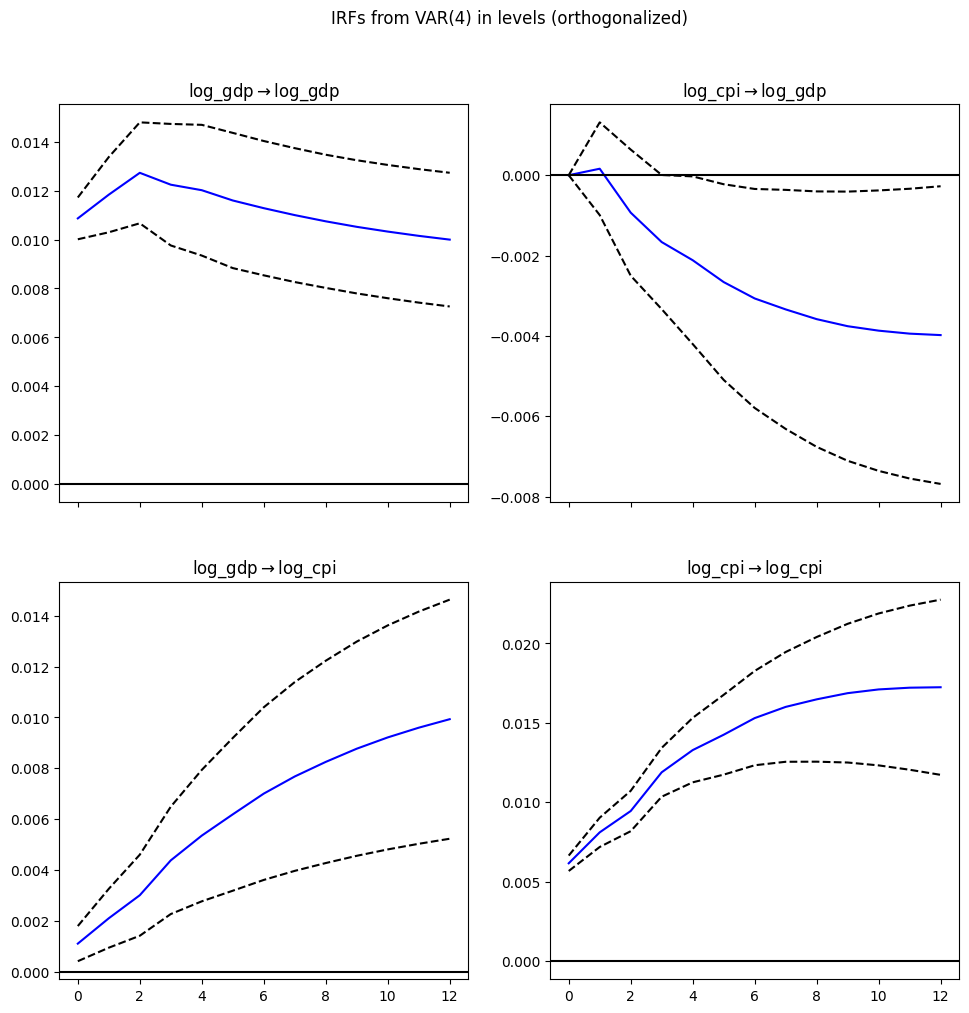

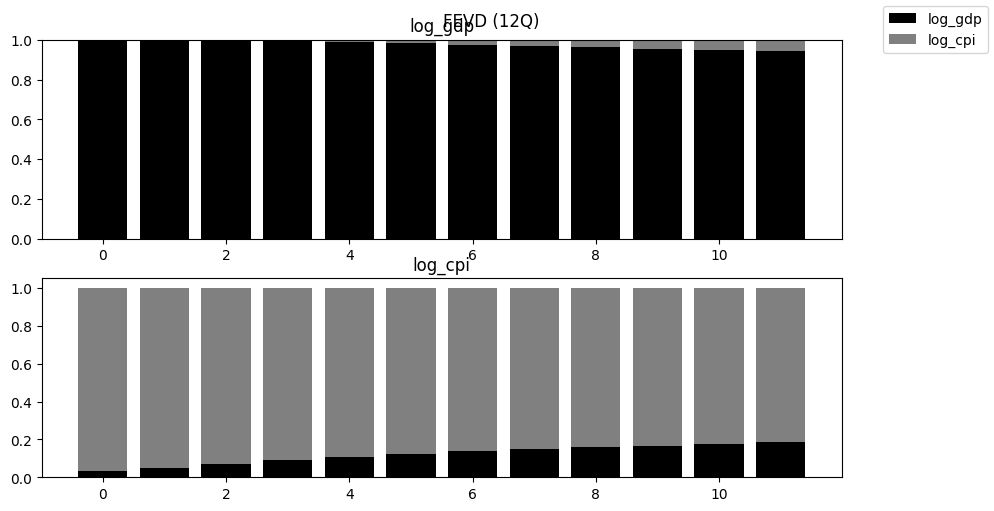

In [22]:
# IRF plots directly from statsmodels
fig = irf_cpi.plot(orth=True)   # full IRF grid
plt.suptitle("IRFs from VAR(4) in levels (orthogonalized)", y=1.02)
plt.show()

# FEVD bar/line for GDP at horizon 12
fig = fevd.plot(figsize=(10,5))
plt.suptitle("FEVD (12Q)")
plt.show()


## Interpretations: IRFs and FEVDs

The impulse responses and variance decompositions together characterize the macro transmission mechanics underlying this VAR(4) model.
Positive GDP shocks are persistent but gradually mean-reverting, consistent with cyclical momentum that dissipates over time.


+ GDP → CPI: Growth shocks raise inflation steadily for several quarters — an expansionary phase consistent with demand-driven inflation.


+ CPI → GDP: Inflation shocks exert a short-run drag on growth, fading by about the sixth quarter as monetary and real adjustments restore equilibrium.


+ CPI → CPI: Inflation inertia remains strong, though the effect plateaus beyond 8–10 quarters.


From the FEVD analysis, GDP’s uncertainty is primarily self-explained, while CPI’s variance shows moderate dependence on GDP shocks, confirming limited but meaningful spillovers from real activity to price dynamics.
For scenario design, this implies:
+ Inflation scenarios should propagate slowly and persist over several quarters.


+ Recession scenarios should exhibit sharper but shorter-lived GDP adjustments.


+ Stagflation scenarios can be built by combining these responses — prolonged inflation pressure coexisting with transitory growth weakness.
